<a href="https://colab.research.google.com/github/anathayna/tcc/blob/main/tcc_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="orange">**TCC: Classificação do discurso de ódio em memes (treinamento)**</font>

O Google Colab é uma plataforma baseada em Jupyter Notebook que oferece um ambiente de execução em nuvem com recursos gratuitos de GPU e TPU, amplamente utilizado em projetos de aprendizado de máquina e ciência de dados.

Este notebook documenta a etapa de treinamento do trabalho de conclusão de curso, cujo objetivo é classificar discursos de ódio em memes por meio de técnicas de aprendizado de máquina multimodal.

# <font color="orange">**Sumário**</font>

1.   Instalando bibliotecas e dependências
2.   Preparando o banco de dados
3.   Pré-processamento
4.   Treinamento
5.   Classificação
6.   Avaliação
7.   Conclusão

## <font color="orange">1. Instalando bibliotecas e dependências</font>

In [ ]:
!pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=4eb032a7db35ffaa818915b72b0e70fe9097a4e46374b55e66022619b7a8cd61
  Stored in directory: /root/.cache/pip/wheels/95/0f/04/b17a72024b56a60e499ce1a6313d283ed5ba332407155bee03
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-80bns1nh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-80bns1nh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ec0d5e925093c6f05e63e5a81befdb6a0bc6d9f9f6f0267804d3c94952ce882a
  Stored in directory: /tmp/pip-ephem-wheel-cache-honoiyre/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
!pip install jsonlines

In [ ]:
from googletrans import Translator
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import clip
import os

translator = Translator()

## <font color="orange">2. Preparando o banco de dados</font>

O banco de dados utilizado para a identificação do discurso de ódio em memes é o **Hateful Memes** disponibilizado pela Meta no *Challenge Hateful Memes*, um banco de dados com mais de **10 mil** imagens de memes em inglês, que contêm conteúdo ofensivo relacionado a gênero, raça, religião, orientação sexual, classe social e outros tópicos.

E o conjunto de dados é composto pelas seguintes porcentagens:

- **40%** de memes de ódio multimodal (multimodal hate): memes em que tanto o texto quanto a imagem contribuem para a mensagem de ódio.

- **10%** de memes de ódio unimodal (unimodal hate): memes em que apenas uma das modalidades (texto ou imagem) é suficiente para transmitir o discurso de ódio.

- **20%** de memes com confusão de texto benigna (benign text confounder): memes em que o texto foi alterado para remover o discurso de ódio, mas a imagem ainda pode sugerir um significado ofensivo.

- **20%** de memes com confusão de imagem benigna (benign image confounder): memes em que a imagem foi alterada para remover o discurso de ódio, mas o texto ainda pode sugerir um significado ofensivo.

- **10%** de memes não odiosos aleatórios (random non-hateful): memes que não contêm discurso de ódio, escolhidos aleatoriamente.


Um **confundidor benigno** é, basicamente, uma alteração mínima feita em um meme (seja mudando o texto ou a imagem) que faz com que a classificação dele mude de “odioso” para “não odioso”. A alteração é a menor possível, justamente para garantir que a diferença entre o meme odioso e o benigno seja bem sutil e dependa de uma análise genuína das duas modalidades (texto+imagem).


![](https://drivendata-public-assets.s3.amazonaws.com/memes-overview.png)


**Figura 1:** Exemplo de meme utilizado na competição  
Fonte: DRIVENDATA (2020)

Na figura 1, é possível visualizar que o confundidor benigno de texto altera o texto e mantém a imagem, enquanto o confundidor benigno de imagem altera a imagem e mantém o texto.

Baixe o banco de dados do **Hateful Memes** pela plataforma *Kaggle* no seguinte endereço: https://www.kaggle.com/datasets/williamberrios/hateful-memes

Originalmente, esse conjunto de dados estava disponível no site oficial do desafio (https://hatefulmemeschallenge.com/#download). Entretanto, no momento da elaboração desta pesquisa, o domínio encontrava-se indisponível.

In [ ]:
#@markdown Defina o caminho para o arquivo **.zip** do banco de dados do *Hateful Memes*.
#@markdown **exemplo:** `"/content/drive/MyDrive/hateful_memes.zip"`

PATH_TO_ZIP_FILE = '/content/drive/MyDrive/hateful_memes.zip' #@param {type:"string"}

#@markdown Defina o diretório base para extrair o banco de dados.
#@markdown **exemplo:** `"/content"`

HOME = '/content' #@param {type:"string"}

Após realizar o download do banco de dados e armazená-lo no Google Drive, é necessário integrá-lo ao ambiente do Google Colab para extração das características. Para isso, utilizamos a biblioteca google.colab.drive, que permite montar o Google Drive como um sistema de arquivos virtual no ambiente de execução.

Ao executar o código, o Colab solicitará uma autorização para acessar sua conta do Google Drive. Uma vez concedida a permissão, o Drive será vinculado ao diretório `/content/drive/`, possibilitando a leitura dos arquivos armazenados. Essa abordagem garante acesso contínuo aos dados durante o processamento, sem necessidade de uploads manuais.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Agora, preparamos o ambiente para incorporar a pasta "model", que armazenará o banco de dados e outros arquivos essenciais, garantindo que o projeto possa acessá-los corretamente.

In [ ]:
import os
os.chdir(HOME)
os.getcwd()
os.environ['PYTHONPATH'] += ":/content/model/"

Em seguida, o código realiza a extração automática do banco de dados Hateful Memes (armazenado no formato `.zip`) para o diretório `/content/model/`, disponibilizando os arquivos para as próximas etapas de processamento e análise no notebook.

In [ ]:
import zipfile
zip_path = PATH_TO_ZIP_FILE
extract_path = '/content/model/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
img_dir = '/content/model/hateful_memes/img'

image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']

image_count = 0
for filename in os.listdir(img_dir):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

print(f"total de imagens: {image_count}")

total de imagens: 12140


Após extrair o conteúdo do arquivo ZIP do dataset, é possível verificar que ele contém **12.140** imagens, inclui também a licença de uso, que especifica as regras de utilização, além de arquivos essenciais para o treinamento e avaliação. A estrutura do dataset é a seguinte:

- Pasta `img/` — contém as imagens (formato .png) correspondentes aos memes.
- Arquivos `.jsonl`:
  - **train.jsonl** — conjunto de treinamento, com rótulos disponíveis (0 = non-hateful, 1 = hateful)
  - **dev_seen.jsonl** — conjunto de validação (seen)
  - **dev_unseen.jsonl** — conjunto de validação (unseen)
  - **test_seen.jsonl** — conjunto de teste (seen), sem rótulos
  - **test_unseen.jsonl** — conjunto de teste (unseen), sem rótulos

O formato .jsonl (JSON Lines) significa que cada linha é um objeto JSON independente, ou seja, cada linha representa um exemplo de meme, com campos como id, text, img (caminho da imagem, por exemplo, "img/42953.png") e, quando aplicável, label que representa os rótulo (0 ou 1).

Os termos “seen” (“visto”) e “unseen” (“não visto”) indicam se os memes foram “expostos” durante a fase de desenvolvimento ou não.
- **“Seen”** refere-se a memes que já estiveram visíveis publicamente durante o desenvolvimento.
- **“Unseen”** são memes inéditos, usados para avaliar generalização em dados mais desafiadores ou que não foram expostos previamente.

Os conjuntos de validação são utilizados para medir o desempenho do modelo durante o desenvolvimento, enquanto os conjuntos de teste servem para avaliação final, sem que o modelo conheça os rótulos.

Para facilitar as próximas etapas de treinamento e análise dos dados do dataset, cada arquivo `.jsonl` foi convertido em um **DataFrame**. Isso transforma as linhas de dados semi-estruturados em tabelas organizadas, permitindo visualizar o conteúdo facilmente e preparar os dados para pré-processamento e treinamento de modelos.

In [ ]:
import jsonlines

base_path = '/content/model/hateful_memes/'

def read_jsonl_to_dataframe(jsonl_path):
    data = []
    with jsonlines.open(jsonl_path) as reader:
        for obj in reader:
            data.append(obj)
    return pd.DataFrame(data)

df_train = read_jsonl_to_dataframe(os.path.join(base_path, "train.jsonl"))
df_dev_seen = read_jsonl_to_dataframe(os.path.join(base_path, "dev_seen.jsonl"))
df_dev_unseen = read_jsonl_to_dataframe(os.path.join(base_path, "dev_unseen.jsonl"))
df_test_seen = read_jsonl_to_dataframe(os.path.join(base_path, "test_seen.jsonl"))
df_test_unseen = read_jsonl_to_dataframe(os.path.join(base_path, "test_unseen.jsonl"))

df_train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
print(f"Total entries in train.jsonl: {df_train.shape[0]}")
print(f"Total entries in dev_seen.jsonl: {df_dev_seen.shape[0]}")
print(f"Total entries in dev_unseen.jsonl: {df_dev_unseen.shape[0]}")
print(f"Total entries in test_seen.jsonl: {df_test_seen.shape[0]}")
print(f"Total entries in test_unseen.jsonl: {df_test_unseen.shape[0]}")

Total entries in train.jsonl: 8500
Total entries in dev_seen.jsonl: 500
Total entries in dev_unseen.jsonl: 540
Total entries in test_seen.jsonl: 1000
Total entries in test_unseen.jsonl: 2000


In [ ]:
print("dr_train distribution")

label_map = {0: 'non-hateful', 1: 'hateful'}
value_counts_df = df_train['label'].value_counts().reset_index()
value_counts_df.columns = ['label', 'count']
value_counts_df['%'] = (value_counts_df['count'] / value_counts_df['count'].sum() * 100).map('{:.2f}'.format)
value_counts_df['meaning'] = value_counts_df['label'].map(label_map)
display(value_counts_df.style.hide(axis='index').set_caption("dr_train distribution"))

label,count,%
0,5481,64.48
1,3019,35.52


Para finalizar a preparação do treinamento, os três arquivos `train`, `dev_seen` e `test_seen` foram unidos em um único DataFrame para o treinamento supervisionado. Como esses splits já possuem rótulos definidos, eles facilitam o aprendizado do modelo. Na etapa de validação, serão utilizados os demais arquivos, como **dev_unseen** e **test_unseen**, que contêm exemplos não vistos durante o treinamento.

In [ ]:
splits = ['train', 'dev_seen', 'test_seen']
df = []
for split in splits:
    file_path = os.path.join(base_path, f'{split}.jsonl')
    split_df = pd.read_json(file_path, lines=True)
    split_df['split'] = split
    df.append(split_df)

df = pd.concat(df, axis=0, ignore_index=True)
df['id'] = df['img'].str.split('/').str[1].str.split('.').str[0]
df.index = df['id']
df.index.name = None
print(df.shape)
df.head()

(10000, 5)


,id,img,label,text,split
42953,42953,img/42953.png,0,its their character not their color that matters,train
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train
13894,13894,img/13894.png,0,putting bows on your pet,train
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train


In [ ]:
df['label'].value_counts(normalize=False)

,count
label,
0,6244
1,3756


## <font color="orange">3. Pré-processamento</font>

No primeiro experimento, realizado com a classificação zero-shot do modelo, observou-se que a label binária entre "discurso de ódio" e "não discurso de ódio" não era suficiente para capturar a complexidade do dataset.

Os chamados confundidores benignos, memes que possuem elementos que podem confundir o modelo, mas não configuram discurso de ódio, exigem um tratamento específico.

Portanto, propõe-se um pré-processamento, no qual serão criadas novas labels para melhorar o treinamento do modelo e obter uma acurácia e uma matriz de confusão melhor.

# Agrupando similaridades de texto

In [ ]:
model_dir = '/content/drive/MyDrive/hateful_memes_models/'
sentence_transformer_model_path = os.path.join(model_dir, 'sentence_transformer_model')
os.makedirs(model_dir, exist_ok=True)

print(f"Caminho do diretório de modelos: {model_dir}")
print(f"Caminho do modelo SentenceTransformer: {sentence_transformer_model_path}")

Caminho do diretório de modelos: /content/drive/MyDrive/hateful_memes_models/
Caminho do modelo SentenceTransformer: /content/drive/MyDrive/hateful_memes_models/sentence_transformer_model
Caminho do estado do MultimodalModel: /content/drive/MyDrive/hateful_memes_models/multimodal_model_state_dict.pt


In [ ]:
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"

if os.path.exists(sentence_transformer_model_path):
    print(f"Loading SentenceTransformer model from {sentence_transformer_model_path}")
    model = SentenceTransformer(sentence_transformer_model_path, device=device)
else:
    print("Downloading and saving SentenceTransformer model...")
    model = SentenceTransformer("all-mpnet-base-v2", device=device)
    model.save(sentence_transformer_model_path)
    print(f"SentenceTransformer model saved to {sentence_transformer_model_path}")

sentences = df['text'].tolist()
embeddings = model.encode(sentences, batch_size=32, convert_to_numpy=True, show_progress_bar=True)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize

threshold = 0.72   # similaridade mínima
eps = 1.0 - threshold   # para DBSCAN com metric='cosine'

embeddings = normalize(embeddings, axis=1)

print("Rodando DBSCAN (metric='cosine', eps=%.3f)..." % eps)
cl = DBSCAN(eps=eps, min_samples=2, metric='cosine', n_jobs=-1)
labels = cl.fit_predict(embeddings)  # -1 = ruído (não agrupado)
df['cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()
print(f"Clusters encontrados: {n_clusters}, pontos sem cluster (ruído): {n_noise}")

Rodando DBSCAN (metric='cosine', eps=0.280)...
Clusters encontrados: 1816, pontos sem cluster (ruído): 5040


In [ ]:
def medoids_from_clusters(df, embeddings):
    medoids = {}
    grouped = df.groupby('cluster').indices
    for cluster_id, idxs in grouped.items():
        if cluster_id == -1:
            continue
        idxs = list(idxs)
        if len(idxs) == 1:
            medoids[cluster_id] = idxs[0]
            continue
        emb = embeddings[idxs]  # normalizado
        centroid = emb.mean(axis=0, keepdims=True)
        sims = (emb @ centroid.T).squeeze()
        medoids[cluster_id] = idxs[int(np.argmax(sims))]
    return medoids

medoids = medoids_from_clusters(df, embeddings)

for c in list(medoids.keys())[:10]:
    mi = medoids[c]
    print(f"cluster {c} (size={len(df[df.cluster==c])}) -> idx {mi} id {df.iloc[mi].get('id','')}")
    print("  ", df.iloc[mi]['text'][:200])
    print("---")

for c, group in df.groupby('cluster').head(3).groupby('cluster'):
    if c == -1:
        continue
    print(f"\ncluster {c} exemplos:")
    for _, row in group.iterrows():
        print(" -", row['text'][:180])

A saída de streaming foi truncada nas últimas 5000 linhas.
 - you know you're getting older when you walk by 3 priests and don't even get a look

cluster 615 exemplos:
 - this dude wants to use the same restroom as your daughter liberals call you a bigot if you object
 - this dude wants to use the same restroom as your daughter liberals call you a bigot if you object

cluster 616 exemplos:
 - you with the goat stop that!
 - you with the goat stop that!

cluster 617 exemplos:
 - plays uno that's racist! steals all the green cards
 - "plays uno steals all the green cards"
 - plays uno steals all the green cards

cluster 618 exemplos:
 - you boys ever played hot potato
 - you boys every played hot potato

cluster 619 exemplos:
 - new zealand: dozens dead in mass shooting usa: -first time?
 - new zealand: dozens dead in mass shooting usa: -first time?

cluster 620 exemplos:
 - if being racist means i don't want my country turned into a pile of rocks & goatshit ruled by a barbric cult then 

In [ ]:
df['cluster_text_idx'] = df['cluster'].astype(int)

In [ ]:
labels = df['cluster'].values
unique_clusters = sorted(set(labels) - {-1})
label_map = {old: new for new, old in enumerate(unique_clusters)}

df['cluster_text_idx'] = np.nan

df.loc[df['cluster'] != -1, 'cluster_text_idx'] = df.loc[df['cluster'] != -1, 'cluster'].map(label_map).astype(int)

# atribui clusters únicos para ruído (cada ruído vira um cluster próprio)
next_cluster = len(label_map)
for idx in df[df['cluster'] == -1].index:
    df.at[idx, 'cluster_text_idx'] = next_cluster
    next_cluster += 1

df['cluster_text_idx'] = df['cluster_text_idx'].astype(int)

In [ ]:
df.describe()

,label,cluster,cluster_text_idx
count,10000.000000,10000.000000,10000.000000
mean,0.375600,388.062900,2573.658900
std,0.484302,543.100329,2088.676717
min,0.000000,-1.000000,0.000000
25%,0.000000,-1.000000,723.750000
50%,0.000000,-1.000000,1855.500000
75%,1.000000,708.250000,4355.250000
max,1.000000,1815.000000,6855.000000


In [ ]:
df.head()

,id,img,label,text,split,cluster,cluster_text_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,-1,1816
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,-1,1817
13894,13894,img/13894.png,0,putting bows on your pet,train,0,0
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,-1,1818
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,-1,1819


In [ ]:
scores_tr = embeddings @ embeddings.T
scores_tr = np.asarray(scores_tr, dtype=float)
np.fill_diagonal(scores_tr, 0.0)

triu = np.triu(scores_tr, k=1)
i_idxs, j_idxs = np.where(triu > threshold)
sims = triu[i_idxs, j_idxs]
order = np.argsort(-sims)
i_idxs, j_idxs, sims = i_idxs[order], j_idxs[order], sims[order]

print(f"total de pares com similaridade > {threshold}: {len(sims)}")

clusters_arr = df['cluster_text_idx'].values if 'cluster_text_idx' in df.columns else df['cluster'].values
intra_mask = clusters_arr[i_idxs] == clusters_arr[j_idxs]
intra_pairs = [(int(i), int(j), float(s)) for i,j,s in zip(i_idxs[intra_mask], j_idxs[intra_mask], sims[intra_mask])]
inter_pairs = [(int(i), int(j), float(s)) for i,j,s in zip(i_idxs[~intra_mask], j_idxs[~intra_mask], sims[~intra_mask])]

print(f"pares intra-cluster: {len(intra_pairs)} — pares inter-cluster: {len(inter_pairs)}")

def show_pair(i, j, sim_value, df, img_dir=None, translate=False, max_text=400):
    id_i = df.iloc[i].get('id', i); id_j = df.iloc[j].get('id', j)
    text_i = str(df.iloc[i]['text']); text_j = str(df.iloc[j]['text'])
    print(f"idx {i} (id={id_i})  <->  idx {j} (id={id_j})  |  sim={sim_value:.4f}")
    print("text:", text_i[:max_text])
    if translate and translator is not None:
        try:
            print("translate:", translator.translate(text_i, src='en', dest='pt').text)
        except Exception as e:
            print("❌ error na tradução", e)
    if img_dir is not None and 'img' in df.columns:
        pi = f"{img_dir}/{df.iloc[i]['img'].split('/')[-1]}"
        pj = f"{img_dir}/{df.iloc[j]['img'].split('/')[-1]}"
        try:
            fig, axes = plt.subplots(1,2,figsize=(10,5))
            axes[0].imshow(Image.open(pi)); axes[0].axis('off'); axes[0].set_title(f"idx {i} id {id_i}")
            axes[1].imshow(Image.open(pj)); axes[1].axis('off'); axes[1].set_title(f"idx {j} id {id_j}")
            plt.suptitle(f"sim={sim_value:.4f}")
            plt.show()
        except Exception as e:
            print("❌ error ao abrir imagens", e)
    print("-"*40)

K = 5
for (i,j,s) in list(zip(i_idxs, j_idxs, sims))[:K]:
    show_pair(int(i), int(j), float(s), df, img_dir=globals().get('img_dir', None), translate=True)

for (i,j,s) in intra_pairs[:K]:
    show_pair(i, j, s, df, img_dir=globals().get('img_dir', None), translate=True)

# Agrupando similaridades de imagem

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.decomposition import PCA

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_fp = os.path.join(self.data_dir, self.df.loc[idx, 'img'])
        img = Image.open(img_fp).convert('RGB')
        return self.transform(img), idx

def extract_embeddings(df, data_dir, batch_size=64, device=None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.eval().to(device)
    feat_extractor = create_feature_extractor(model, return_nodes={'avgpool':'features'})
    transform = T.Compose([
        T.Resize((224, 224)), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    ds = ImageDataset(df, data_dir, transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2)
    embeddings = np.zeros((len(df), 512), dtype=np.float32)
    with torch.no_grad():
        for imgs, idxs in loader:
            imgs = imgs.to(device)
            feats = feat_extractor(imgs)['features'].squeeze()
            feats = feats / (feats.norm(dim=1, keepdim=True) + 1e-10)
            embeddings[list(idxs.numpy())] = feats.cpu().numpy()
    return embeddings

def cluster_embeddings(embeddings, similarity=0.92, min_samples=2):
    eps = 1 - similarity
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    return db.fit_predict(embeddings)

def show_clusters(df, data_dir, labels, n_show=5, n_img=3):
    df2 = df.copy(); df2['cluster'] = labels
    clusters = [c for c in np.unique(labels) if c != -1][:n_show]
    for c in clusters:
        imgs_df = df2[df2.cluster == c]
        print(f"cluster {c}: {len(imgs_df)} imagens")
        sample = imgs_df.sample(min(n_img, len(imgs_df)), random_state=0)
        fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
        if len(sample) == 1: axes = [axes]
        for ax, (_, row) in zip(axes, sample.iterrows()):
            img = Image.open(os.path.join(data_dir, row['img']))
            ax.imshow(img); ax.axis('off')
        plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


cluster 0: 2 imagens


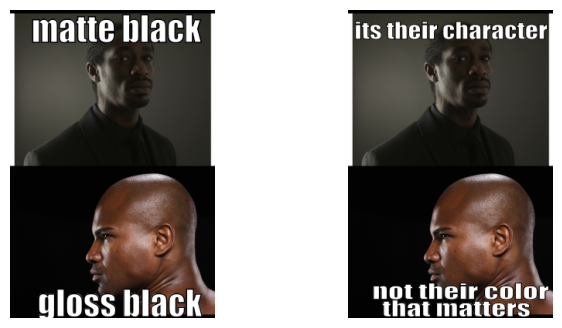

cluster 1: 2 imagens


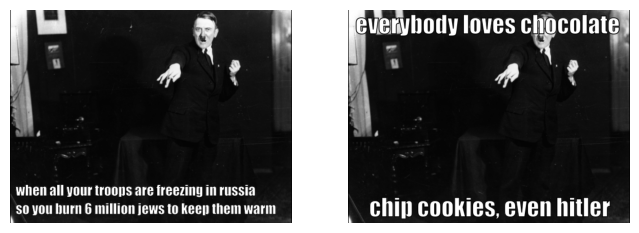

cluster 2: 2 imagens


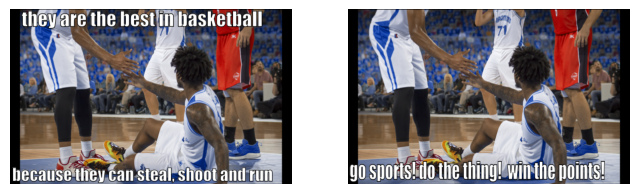

In [ ]:
data_dir = '/content/model/hateful_memes/'

df = df.dropna(subset=['img']).copy()

embeddings_image = extract_embeddings(df, data_dir, batch_size=64)
labels_img = cluster_embeddings(embeddings_image, similarity=0.92, min_samples=2)

temp_cluster_img_idx = pd.Series(np.nan, index=df.index)

unique_clusters_img = sorted(set(labels_img) - {-1})
label_map_img = {old: new for new, old in enumerate(unique_clusters_img)}

non_noise_mask = (labels_img != -1)
temp_cluster_img_idx.iloc[non_noise_mask] = np.vectorize(label_map_img.get)(labels_img[non_noise_mask])

next_cluster_img = len(label_map_img)
noise_indices_img = np.where(labels_img == -1)[0]

for idx_pos in noise_indices_img:
    temp_cluster_img_idx.iloc[idx_pos] = next_cluster_img
    next_cluster_img += 1

df['cluster_img_idx'] = temp_cluster_img_idx.astype(int)

show_clusters(df, data_dir, df['cluster_img_idx'].values, n_show=3, n_img=4)

In [ ]:
df.head()

,id,img,label,text,split,cluster,cluster_text_idx,cluster_img_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,-1,1816,0
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,-1,1817,1619
13894,13894,img/13894.png,0,putting bows on your pet,train,0,0,1620
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,-1,1818,1621
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,-1,1819,1


In [ ]:
df.nunique()

,0
id,10000
img,10000
label,2
text,8045
split,3
cluster,1817
cluster_text_idx,6856
cluster_img_idx,7356


In [ ]:
file_path = f'{data_dir}/preprocessing.csv'
df.to_csv(file_path, index=False)

## <font color="orange">4. Treinamento</font>

In [ ]:
class HatefulMemesDataset(Dataset):
    def __init__(self, dataframe, data_dir, preprocess):
        self.dataframe = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.preprocess = preprocess

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.data_dir, row['img'])
        image = Image.open(img_path).convert('RGB')
        image = self.preprocess(image)  # tensor [3,H,W]

        text = row['text']
        label = float(row['label'])
        cluster_text_idx = int(row['cluster_text_idx'])
        cluster_img_idx = int(row['cluster_img_idx'])

        text_tokens = clip.tokenize(text, truncate=True).squeeze(0)

        return {
            'image': image,
            'text_tokens': text_tokens,
            'label': torch.tensor(label, dtype=torch.float32),
            'cluster_text_idx': torch.tensor(cluster_text_idx, dtype=torch.long),
            'cluster_img_idx': torch.tensor(cluster_img_idx, dtype=torch.long),
        }

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MultimodalModel(nn.Module):
    def __init__(self, clip_model, num_cluster_text_idxs, num_cluster_img_idxs, freeze_clip=True):
        super().__init__()
        self.clip_model = clip_model

        if freeze_clip:
            for p in self.clip_model.parameters():
                p.requires_grad = False

        clip_feature_dim = 512  # ViT-B/32 CLIP embedding dim
        embedding_dim = 64

        self.cluster_text_idx_embedding = nn.Embedding(num_cluster_text_idxs, embedding_dim)
        self.cluster_img_idx_embedding = nn.Embedding(num_cluster_img_idxs, embedding_dim)

        self.bn = nn.BatchNorm1d(clip_feature_dim * 2 + embedding_dim * 2)
        self.dropout = nn.Dropout(0.2)

        self.classifier = nn.Linear(clip_feature_dim * 2 + embedding_dim * 2, 1)

    def forward(self, image, text_tokens, cluster_text_idx, cluster_img_idx):
        image_features = self.clip_model.encode_image(image)
        text_features = self.clip_model.encode_text(text_tokens)

        cluster_text_idx_embedded = self.cluster_text_idx_embedding(cluster_text_idx)
        cluster_img_idx_embedded = self.cluster_img_idx_embedding(cluster_img_idx)

        combined_features = torch.cat((
            image_features,
            text_features,
            cluster_text_idx_embedded,
            cluster_img_idx_embedded
        ), dim=1)

        x = self.dropout(self.bn(combined_features))
        logits = self.classifier(x)
        return logits.squeeze(1)

In [ ]:
multimodal_model_state_dict_path = os.path.join(model_dir, 'multimodal_model_state_dict.pt')
print(f"Caminho do estado do MultimodalModel: {multimodal_model_state_dict_path}") # trainning results

In [ ]:
torch.save(model.state_dict(), multimodal_model_state_dict_path)
print(f"MultimodalModel state_dict salvo em: {multimodal_model_state_dict_path}")

In [ ]:
loaded_model = MultimodalModel(
    clip_model,
    num_cluster_text_idxs,
    num_cluster_img_idxs,
    freeze_clip=True # Keep CLIP frozen as it was during training
).to(device)

loaded_model.load_state_dict(torch.load(multimodal_model_state_dict_path, map_location=device), strict=False)

loaded_model.eval()

print("MultimodalModel carregado e definido para o modo de avaliação.")

In [ ]:
from torchvision import transforms

data_dir = '/content/model/hateful_memes/'

full_df = pd.read_csv(f'{data_dir}/preprocessing.csv')

train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)

num_cluster_text_idxs = int(full_df['cluster_text_idx'].max()) + 1
num_cluster_img_idxs = int(full_df['cluster_img_idx'].max()) + 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

batch_size = 32

dataset = HatefulMemesDataset(train_df, data_dir, clip_preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)

model = MultimodalModel(
    clip_model,
    num_cluster_text_idxs,
    num_cluster_img_idxs,
    freeze_clip=True
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

100%|████████████████████████████████████████| 338M/338M [00:00<00:00, 504MiB/s]


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        images = batch['image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        labels = batch['label'].to(device)
        cluster_text_idx = batch['cluster_text_idx'].to(device)
        cluster_img_idx = batch['cluster_img_idx'].to(device)

        optimizer.zero_grad()
        outputs = model(images, text_tokens, cluster_text_idx, cluster_img_idx)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        all_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = epoch_loss / len(dataset)
    preds_bin = [1 if p>0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, preds_bin)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except:
        auc = -1

    print(f"epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - acc: {acc:.4f} - AUC: {auc:.4f}")

epoch 1/10 - loss: 0.6791 - acc: 0.5873 - AUC: 0.5869
epoch 2/10 - loss: 0.5901 - acc: 0.6889 - AUC: 0.7106
epoch 3/10 - loss: 0.5592 - acc: 0.7231 - AUC: 0.7489
epoch 4/10 - loss: 0.5391 - acc: 0.7296 - AUC: 0.7728
epoch 5/10 - loss: 0.5282 - acc: 0.7435 - AUC: 0.7850
epoch 6/10 - loss: 0.5144 - acc: 0.7486 - AUC: 0.7993
epoch 7/10 - loss: 0.5064 - acc: 0.7546 - AUC: 0.8075
epoch 8/10 - loss: 0.5000 - acc: 0.7568 - AUC: 0.8131
epoch 9/10 - loss: 0.4933 - acc: 0.7627 - AUC: 0.8201
epoch 10/10 - loss: 0.4917 - acc: 0.7604 - AUC: 0.8211


## <font color="orange">5. Classificação</font>

## <font color="orange">6. Avaliação</font>

## <font color="orange">7. Conclusão</font>